# Aim 

**We will design a predictive model to predict full-load power output of Combined Cycle Power Plant Dataset from UCI website and evaluate the performance of the model.**

**Includes Linear Regression, its assumptions and regularization. Also Random Forest Regressor model**

https://archive.ics.uci.edu/ml/datasets/Combined+Cycle+Power+Plant

# About Data Set

The dataset contains 9568 data points collected from a Combined Cycle Power Plant over 6 years (2006-2011), when the power plant was set to work with full load. Features consist of hourly average ambient variables Temperature (T), Ambient Pressure (AP), Relative Humidity (RH) and Exhaust Vacuum (V) to predict the net hourly electrical energy output (EP) of the plant.

# Attribute Info

Features consist of hourly average ambient variables:
- Temperature (T) in the range 1.81°C and 37.11°C,
- Ambient Pressure (AP) in the range 992.89-1033.30 milibar,
- Relative Humidity (RH) in the range 25.56% to 100.16%
- Exhaust Vacuum (V) in teh range 25.36-81.56 cm Hg

Target is:
- Net hourly electrical energy output (PE) 420.26-495.76 MW

The averages are taken from various sensors located around the plant that record the ambient variables every second. The variables are given without normalization.

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn import preprocessing
from sklearn import model_selection
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import Ridge , Lasso
from sklearn.linear_model import RidgeCV
from statsmodels.stats.descriptivestats import Description
from statsmodels.stats.diagnostic import het_goldfeldquandt
from scipy.stats import shapiro
from sklearn.datasets import make_regression
from statsmodels.stats.diagnostic import normal_ad
import statsmodels.api as sm

# Loading Dataset

In [2]:
df=pd.read_excel("Folds5x2_pp.xlsx")
df.head()

,AT,V,AP,RH,PE
0,14.96,41.76,1024.07,73.17,463.26
1,25.18,62.96,1020.04,59.08,444.37
2,5.11,39.40,1012.16,92.14,488.56
3,20.86,57.32,1010.24,76.64,446.48
4,10.82,37.50,1009.23,96.62,473.90


In [3]:
df.shape

(9568, 5)

# Summary statistics

In [4]:
df.info()
df.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9568 entries, 0 to 9567
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   AT      9568 non-null   float64
 1   V       9568 non-null   float64
 2   AP      9568 non-null   float64
 3   RH      9568 non-null   float64
 4   PE      9568 non-null   float64
dtypes: float64(5)
memory usage: 373.9 KB


,AT,V,AP,RH,PE
count,9568.000000,9568.000000,9568.000000,9568.000000,9568.000000
mean,19.651231,54.305804,1013.259078,73.308978,454.365009
std,7.452473,12.707893,5.938784,14.600269,17.066995
min,1.810000,25.360000,992.890000,25.560000,420.260000
25%,13.510000,41.740000,1009.100000,63.327500,439.750000
50%,20.345000,52.080000,1012.940000,74.975000,451.550000
75%,25.720000,66.540000,1017.260000,84.830000,468.430000
max,37.110000,81.560000,1033.300000,100.160000,495.760000


# Checking for outliers

<AxesSubplot:>

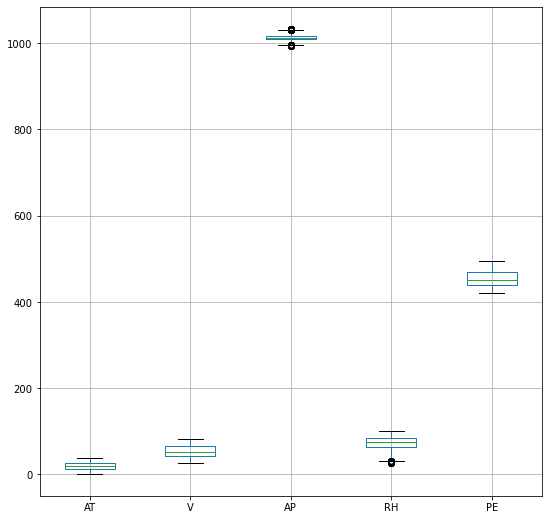

In [5]:
plt.figure(figsize=(9,9))
df.boxplot()

**Closely checking AP and RH as they seem to have outliers in the above graph**

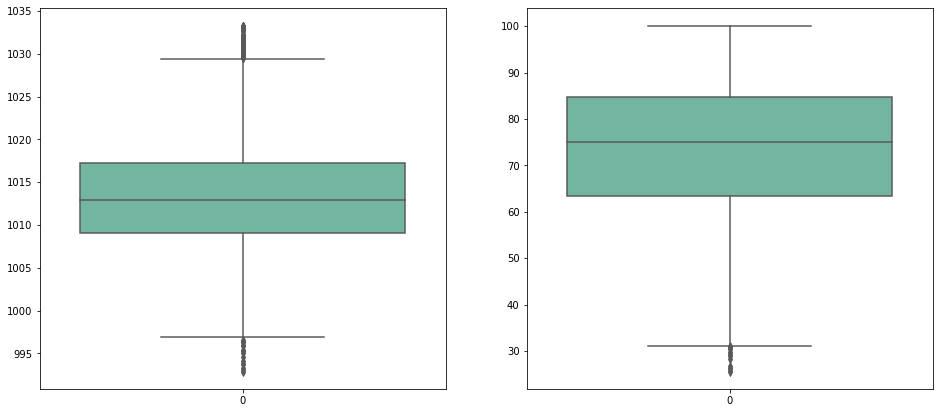

In [6]:
fig, axes = plt.subplots(1, 2, figsize=(16,7))
sns.boxplot(data=df["AP"], orient="v", ax=axes[0], palette="Set2")
sns.boxplot(data=df["RH"], orient="v", ax=axes[1], palette="Set2")
plt.show()

# Checking correlation of features with the target (PE)

[]

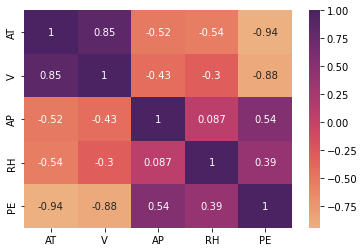

In [7]:
sns.heatmap(df.corr(method="spearman"), annot=True, cmap='flare')
plt.plot()

**We can see that AT and V have a strong negative correlation with the target variable (PE) as their correlation coefficients are -0.94 and -0.88 respectively. AP and RH have a weak positive correlation with PE with correlation coefficients of 0.54 and 0.39.**

In [8]:
X=df.iloc[:,0:4] # Feature matrix
y=df.iloc[:,4]  # Target vector

# Assumptions of Linear Regression
https://jeffmacaluso.github.io/post/LinearRegressionAssumptions/

We are creating artificial linear data using the same number of features and observations as the
Combined Cycle Power Plant dataset for assumption test comparison

In [9]:
linear_X, linear_y = make_regression(df.shape[0],X.shape[1],noise=50,random_state=42)

In [10]:
# Fitting the model for the linear dataset
linear_model = LinearRegression()
linear_model.fit(linear_X, linear_y)

# Returning the R^2 for the model
linear_r2 = linear_model.score(linear_X, linear_y)
print('R^2: {0}'.format(linear_r2))

R^2: 0.8718535790241014


In [11]:
# Fitting the model for CCPP dataset
ccpp_model = LinearRegression()
ccpp_model.fit(X, y)

# Returning the R^2 for the model
ccpp_r2 = ccpp_model.score(X, y)
print('R^2: {0}'.format(ccpp_r2))

R^2: 0.9286960898122536


/opt/anaconda3/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:>

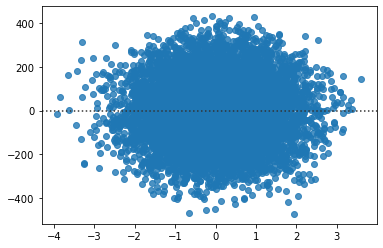

In [12]:
sns.residplot(linear_X[:,0],linear_y)

In [13]:
# Creates predictions on the features with the model and calculates residuals
def residual(model,feature,label):
    pred=model.predict(feature)
    df2=pd.DataFrame({"Actual":label,"Predicted":pred})
    df2["Residuals"]=df2["Actual"]-df2["Predicted"]
    return df2

## Test for Linearity

This assumes that there is a linear relationship between the predictors (e.g. independent variables or features) and the response variable (e.g. dependent variable or label). This also assumes that the predictors are additive. <br>
<b>Why it can happen: </b>There may not just be a linear relationship among the data. Modeling is about trying to estimate a function that explains a process, and linear regression would not be a fitting estimator if there is no linear relationship.

In [14]:
def linear_assumption(model, features, label):
    """
    Linearity: Assumes that there is a linear relationship between the predictors and
               the response variable. If not, either a quadratic term or another
               algorithm should be used.
    """
    print('Linearity: Linear Relationship between the Target and the Feature', '\n')
        
    print('Checking with a scatter plot of actual vs. predicted.',
           'Predictions should follow the diagonal line.')
    
    # Calculating residuals for the plot
    df_results = residual(model, features, label)
    
    # print(df_results)
    
    # Plotting the actual vs predicted values
    sns.lmplot(x='Actual', y='Predicted', data=df_results, fit_reg=False, height=7)
        
    # Plotting the diagonal line
    line_coords = np.arange(df_results.min().min(), df_results.max().max())
    plt.plot(line_coords, line_coords,  # X and y points
             color='darkorange', linestyle='--')
    plt.title('Actual vs. Predicted')
    plt.show()

We'll start with our linear dataset:

In [15]:
residual(linear_model, linear_X, linear_y)

,Actual,Predicted,Residuals
0,0.269606,23.730296,-23.460691
1,121.310052,137.665333,-16.355281
2,-104.457438,-79.603238,-24.854201
3,150.015510,33.828147,116.187363
4,63.790566,114.527166,-50.736600
...,...,...,...
9563,25.619838,-28.925408,54.545246
9564,183.680479,130.659426,53.021053
9565,-95.899009,-150.390863,54.491854
9566,119.136114,102.937495,16.198620


Linearity: Linear Relationship between the Target and the Feature 

Checking with a scatter plot of actual vs. predicted. Predictions should follow the diagonal line.


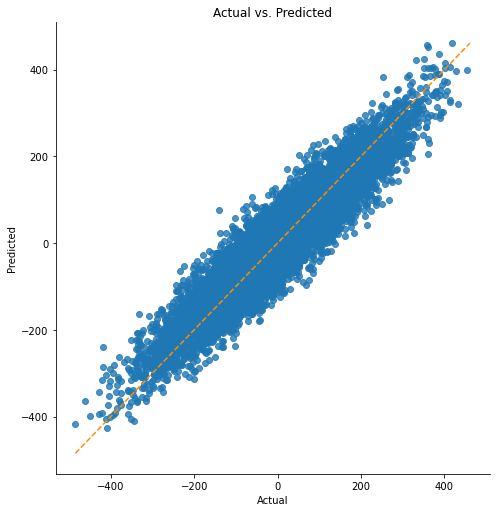

In [16]:
linear_assumption(linear_model, linear_X, linear_y)

We can see a relatively even spread around the diagonal line.

Now, let’s compare it to the Boston dataset:

In [17]:
residual(ccpp_model, X, y)

,Actual,Predicted,Residuals
0,463.26,467.269790,-4.009790
1,444.37,444.077366,0.292634
2,488.56,483.562643,4.997357
3,446.48,450.555668,-4.075668
4,473.90,471.825499,2.074501
...,...,...,...
9563,460.03,458.630177,1.399823
9564,469.62,472.358625,-2.738625
9565,429.57,432.405798,-2.835798
9566,435.74,443.036676,-7.296676


Linearity: Linear Relationship between the Target and the Feature 

Checking with a scatter plot of actual vs. predicted. Predictions should follow the diagonal line.


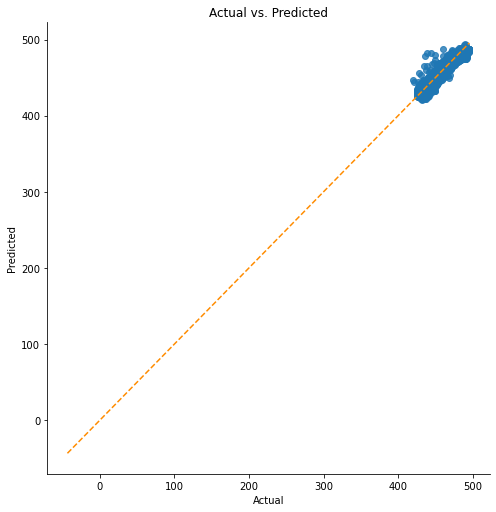

In [18]:
linear_assumption(ccpp_model, X, y)

We can see in this case that there is not a perfect linear relationship. Our predictions are biased towards higher values for around 400.

## Test for Normality
More specifically, this assumes that the error terms of the model are normally distributed. Linear regressions other than Ordinary Least Squares (OLS) may also assume normality of the predictors or the label, but that is not the case here. <br><br>
<b>Why it can happen:</b> This can actually happen if either the predictors or the label are significantly non-normal. Other potential reasons could include the linearity assumption being violated or outliers affecting our model.<br>

<b>What it will affect: </b>A violation of this assumption could cause issues with either shrinking or inflating our confidence intervals. <br>

<b>How to detect it: </b>There are a variety of ways to do so, but we’ll look at both a histogram and the p-value from the Anderson-Darling test for normality. <br>

<b>How to fix it: </b> It depends on the root cause, but there are a few options. Nonlinear transformations of the variables, excluding specific variables (such as long-tailed variables), or removing outliers may solve this problem.

In [19]:
def normal_errors_assumption(model, features, label, p_value_thresh=0.05):
    """
    Normality: Assumes that the error terms are normally distributed. If they are not,
    nonlinear transformations of variables may solve this.
               
    This assumption being violated primarily causes issues with the confidence intervals
    """
    print('Normality: The error terms are normally distributed', '\n')
    
    # Calculating residuals for the Anderson-Darling test
    df_results = residual(model, features, label)
    
    print('Using the Anderson-Darling test for normal distribution')

    # Performing the test on the residuals
    p_value = normal_ad(df_results['Residuals'])[1]
    print('p-value from the test - below 0.05 generally means non-normal:', p_value)
    
    # Reporting the normality of the residuals
    if p_value < p_value_thresh:
        print('Residuals are not normally distributed')
    else:
        print('Residuals are normally distributed')
    
    # Plotting the residuals distribution
    plt.title('Distribution of Residuals')
    sns.distplot(df_results['Residuals'])
    plt.show()
    
    print()
    if p_value > p_value_thresh:
        print('Assumption satisfied')
    else:
        print('Assumption not satisfied')
        print()
        print('Confidence intervals will likely be affected')
        print('Try performing nonlinear transformations on variables')

As with our previous assumption, we’ll start with the linear dataset:

Normality: The error terms are normally distributed 

Using the Anderson-Darling test for normal distribution
p-value from the test - below 0.05 generally means non-normal: 0.9220047242470982
Residuals are normally distributed


/opt/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


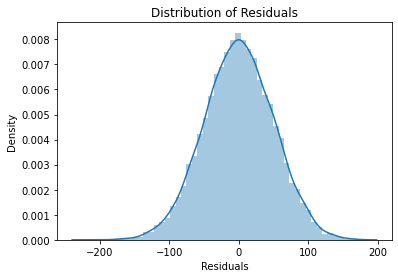


Assumption satisfied


In [20]:
normal_errors_assumption(linear_model, linear_X, linear_y)

Now let’s run the same test on the CCPP dataset:

Normality: The error terms are normally distributed 

Using the Anderson-Darling test for normal distribution
p-value from the test - below 0.05 generally means non-normal: 2.585224173208246e-22
Residuals are not normally distributed


/opt/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


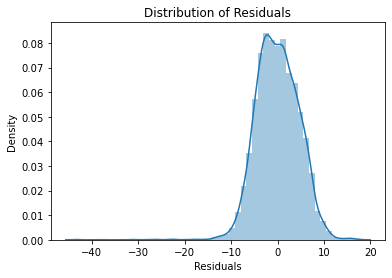


Assumption not satisfied

Confidence intervals will likely be affected
Try performing nonlinear transformations on variables


In [21]:
normal_errors_assumption(ccpp_model, X, y)

In [22]:
#perform Shapiro-Wilk test
shapiro(X)

/opt/anaconda3/lib/python3.8/site-packages/scipy/stats/morestats.py:1760: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


ShapiroResult(statistic=0.5875012874603271, pvalue=0.0)

In [23]:
from statsmodels.stats.stattools import jarque_bera
def Normality_test(model,X,y,thres=0.05):
    df_res=residual(model,X,y)
    _,p_val=normal_ad(df_res["Residuals"])
    _,jp_val,_,_=jarque_bera(df_res["Residuals"])
    print(p_val)
    print(jp_val)
    if p_val<thres:
        print("they are not normally distributed")
    else:
        print("normally distributed")
    sns.histplot(df_res["Residuals"],kde=True)

In [24]:
Description(X).summary()

nobs,9568.0,9568.0,9568.0,9568.0
missing,0.0,0.0,0.0,0.0
mean,19.65123118729102,54.30580372073601,1013.2590781772603,73.30897784280926
std_err,0.0007788956134626974,0.0013281660742398486,0.0006206922769451914,0.0015259478215644785
upper_ci,19.652757794641126,54.308406878407006,1013.2602947117687,73.31196864558181
lower_ci,19.649704579940916,54.30320056306501,1013.257861642752,73.3059870400367
std,7.452473229611089,12.707892998326871,5.938783705811591,14.60026875672893
iqr,12.209999999999999,24.800000000000004,8.159999999999968,21.502499999999998
iqr_normal,9.0512865439767,18.384267509469467,6.049017051502832,15.939827101708351
mad,6.426435756713474,11.64141626019984,4.733132465922617,12.021272449325913
mad_normal,8.05434278643883,14.590351577282998,5.932101833327791,15.066430709261496


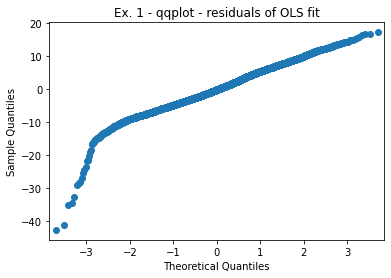

In [25]:
model = sm.OLS(y, X)
mod_fit = model.fit()
res = mod_fit.resid # residuals
pplot = sm.ProbPlot(res)
fig = pplot.qqplot()
h = plt.title("Ex. 1 - qqplot - residuals of OLS fit")
plt.show()

0.0
0.0
they are not normally distributed


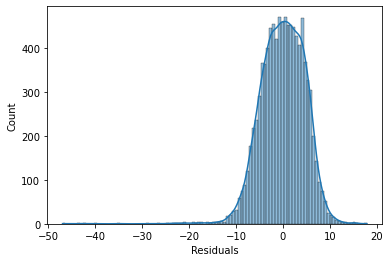

In [26]:
from sklearn.preprocessing import FunctionTransformer
transformer = FunctionTransformer(np.log1p)
X=transformer.transform(X)
lr_transform=LinearRegression()
lr_transform.fit(X,y)
Normality_test(lr_transform,X,y)

This isn’t ideal, and we can see that our model is biasing towards under-estimating.

## Test for Multicolinearity
This assumes that the predictors used in the regression are not correlated with each other. This won’t render our model unusable if violated, but it will cause issues with the interpretability of the model.
<br>
<b>How to fix it: </b>This can be fixed by other removing predictors with a high variance inflation factor (VIF) or performing dimensionality reduction.

In [27]:
def multicollinearity_assumption(model, features, label, feature_names=None):
    """
    Multicollinearity: Assumes that predictors are not correlated with each other. If there is
                       correlation among the predictors, then either remove prepdictors with high
                       Variance Inflation Factor (VIF) values or perform dimensionality reduction
                           
                       This assumption being violated causes issues with interpretability of the 
                       coefficients and the standard errors of the coefficients.
    """
    from statsmodels.stats.outliers_influence import variance_inflation_factor
    print('Multicolinearity: Little to no multicollinearity among predictors')
        
    # Plotting the heatmap

    sns.heatmap(pd.DataFrame(features, columns=feature_names).corr(), annot=True)
    plt.title('Correlation of Variables')
    plt.show()
        
    print('Variance Inflation Factors (VIF)')
    print('> 10: An indication that multicollinearity may be present')
    print('> 100: Certain multicollinearity among the variables')
    print('-------------------------------------')
       
    # Gathering the VIF for each variable
    VIF = [variance_inflation_factor(features, i) for i in range(features.shape[1])]
    for idx, vif in enumerate(VIF):
        print('{0}: {1}'.format(feature_names[idx], vif))
        
    # Gathering and printing total cases of possible or definite multicollinearity
    possible_multicollinearity = sum([1 for vif in VIF if vif > 10])
    definite_multicollinearity = sum([1 for vif in VIF if vif > 100])
    print()
    print('{0} cases of possible multicollinearity'.format(possible_multicollinearity))
    print('{0} cases of definite multicollinearity'.format(definite_multicollinearity))
    print()

    if definite_multicollinearity == 0:
        if possible_multicollinearity == 0:
            print('Assumption satisfied')
        else:
            print('Assumption possibly satisfied')
            print()
            print('Coefficient interpretability may be problematic')
            print('Consider removing variables with a high Variance Inflation Factor (VIF)')

    else:
        print('Assumption not satisfied')
        print()
        print('Coefficient interpretability will be problematic')
        print('Consider removing variables with a high Variance Inflation Factor (VIF)')

Starting with the linear dataset:

In [28]:
name = ["x"+str(i+1)for i in range(linear_X.shape[1])]
name

['x1', 'x2', 'x3', 'x4']

Multicolinearity: Little to no multicollinearity among predictors


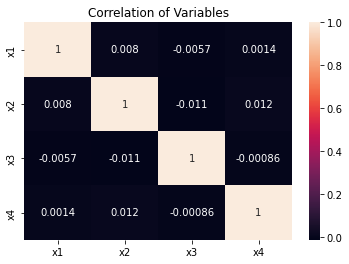

Variance Inflation Factors (VIF)
> 10: An indication that multicollinearity may be present
> 100: Certain multicollinearity among the variables
-------------------------------------
x1: 1.0000965414593637
x2: 1.000324682673306
x3: 1.0001612241015272
x4: 1.0001373538053737

0 cases of possible multicollinearity
0 cases of definite multicollinearity

Assumption satisfied


In [29]:
multicollinearity_assumption(linear_model, linear_X, linear_y, name)

Multicolinearity: Little to no multicollinearity among predictors


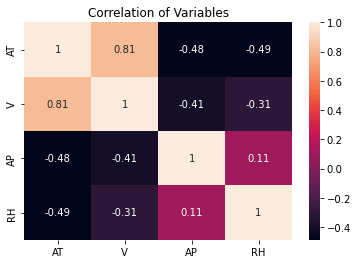

Variance Inflation Factors (VIF)
> 10: An indication that multicollinearity may be present
> 100: Certain multicollinearity among the variables
-------------------------------------
AT: 178.43666760829936
V: 904.3010851311749
AP: 990.0641449514949
RH: 534.1091044181178

4 cases of possible multicollinearity
4 cases of definite multicollinearity

Assumption not satisfied

Coefficient interpretability will be problematic
Consider removing variables with a high Variance Inflation Factor (VIF)


In [30]:
multicollinearity_assumption(ccpp_model, X, y, X.columns)

<b>There is multicollinearity for all of the variables in this dataset.</b>

**** Now have to study what to do in that case 

## Test for Homoscedasticity

This assumes homoscedasticity, which is the same variance within our error terms. Heteroscedasticity, the violation of homoscedasticity, occurs when we don’t have an even variance across the error terms.<br>

<b>Why it can happen: </b>Our model may be giving too much weight to a subset of the data, particularly where the error variance was the largest.<br>

<b>What it will affect: </b>Significance tests for coefficients due to the standard errors being biased. Additionally, the confidence intervals will be either too wide or too narrow.<br>

<b>How to detect it: </b>Plot the residuals and see if the variance appears to be uniform.

In [31]:
def homoscedasticity_assumption(model, features, label):
    """
    Homoscedasticity: Assumes that the errors exhibit constant variance
    """
    print('Homoscedasticity: Homoscedasticity of Error Terms', '\n')
    
    print('Residuals should have relative constant variance')
        
    # Calculating residuals for the plot
    df_results = residual(model, features, label)

    # Plotting the residuals
    ax = plt.subplot(111)  # To remove spines
    plt.scatter(x=df_results.index, y=df_results.Residuals, alpha=0.5)
    plt.plot(np.repeat(0, df_results.index.max()), color='darkorange', linestyle='--')
    ax.spines['right'].set_visible(False)  # Removing the right spine
    ax.spines['top'].set_visible(False)  # Removing the top spine
    plt.title('Residuals')
    plt.show()  

Plotting the residuals of our ideal dataset:

Homoscedasticity: Homoscedasticity of Error Terms 

Residuals should have relative constant variance


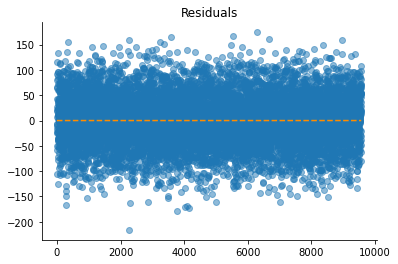

In [32]:
homoscedasticity_assumption(linear_model, linear_X, linear_y)

Next, looking at the residuals of the CCPP dataset:

Homoscedasticity: Homoscedasticity of Error Terms 

Residuals should have relative constant variance


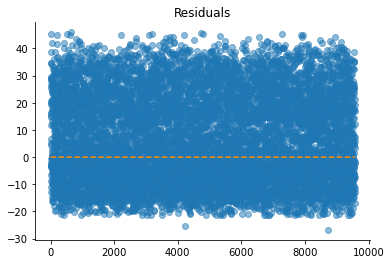

In [33]:
homoscedasticity_assumption(ccpp_model, X, y)

**** Have to study this also and then write comment

In [34]:
residual_normal=residual(ccpp_model,X,y)
residual_normal

,Actual,Predicted,Residuals
0,463.26,448.002650,15.257350
1,444.37,446.962825,-2.592825
2,488.56,449.877935,38.682065
3,446.48,447.299914,-0.819914
4,473.90,448.576704,25.323296
...,...,...,...
9563,460.03,447.729156,12.300844
9564,469.62,448.263875,21.356125
9565,429.57,446.582055,-17.012055
9566,435.74,446.984960,-11.244960


https://www.statology.org/goldfeld-quandt-test-in-r/

The Goldfeld-Quandt test uses the following null and alternative hypotheses:

Null (H0): Homoscedasticity is present.

Alternative (HA): Heteroscedasticity is present.

There are a couple common ways that you can fix this issue, including:

1. Transform the response variable.

You can try performing a transformation on the response variable, such as taking the log, square root, or cube root of the response variable. Typically this can cause heteroscedasticity to go away.

2. Use weighted regression.

Weighted regression assigns a weight to each data point based on the variance of its fitted value. Essentially, this gives small weights to data points that have higher variances, which shrinks their squared residuals.

When the proper weights are used, weighted regression can eliminate the problem of heteroscedasticity.

For linear dataset:

In [35]:
f_val,p_val,ordering=het_goldfeldquandt(linear_y, linear_X)
print(p_val)
if p_val>0.05:
    print("HO: Homoscedasticity is present ")
else:
    print("HA: Heteroscedasticity is present")

0.9292825979335135
HO: Homoscedasticity is present 


For CCPP dataset:

In [36]:
f_val,p_val,ordering=het_goldfeldquandt(y,X)
print(p_val)
if p_val>0.05:
    print("HO: Homoscedasticity is present ")
else:
    print("HA: Heteroscedasticity is present")

0.10920149040801139
HO: Homoscedasticity is present 


In [37]:
from sklearn.preprocessing import FunctionTransformer

transformer = FunctionTransformer(np.log1p)
y_ccpp_transformed=transformer.transform(y)
lr_transform=LinearRegression()
lr_transform.fit(X,y_ccpp_transformed)

LinearRegression()

In [38]:
f_val,p_val,ordering=het_goldfeldquandt(y_ccpp_transformed, X)
print(p_val)
if p_val>0.05:
    print("HO: Homoscedasticity is present ")
else:
    print("HA: Heteroscedasticity is present")

0.05542756582268763
HO: Homoscedasticity is present 


In [39]:
residual(lr_transform,X,y)

,Actual,Predicted,Residuals
0,463.26,6.147965,457.112035
1,444.37,6.097659,438.272341
2,488.56,6.198615,482.361385
3,446.48,6.106401,440.373599
4,473.90,6.161739,467.738261
...,...,...,...
9563,460.03,6.126706,453.903294
9564,469.62,6.158523,463.461477
9565,429.57,6.076958,423.493042
9566,435.74,6.090689,429.649311


Homoscedasticity: Homoscedasticity of Error Terms 

Residuals should have relative constant variance


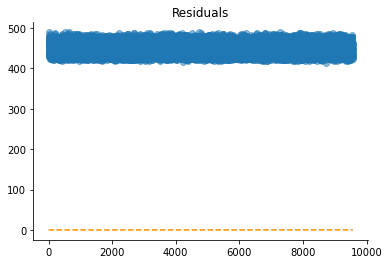

In [40]:
homoscedasticity_assumption(lr_transform,X,y)

**** No idea what happened, have to fix it

## Test for Autocorrelation
This assumes no autocorrelation of the error terms. Autocorrelation being present typically indicates that we are missing some information that should be captured by the model. <br>

<b>Why it can happen: </b>In a time series scenario, there could be information about the past that we aren’t capturing. In a non-time series scenario, our model could be systematically biased by either under or over predicting in certain conditions. Lastly, this could be a result of a violation of the linearity assumption.<br>

<b>What it will affect: </b>This will impact our model estimates. <br>

<b>How to detect it: </b>We will perform a Durbin-Watson test to determine if either positive or negative correlation is present. Alternatively, you could create plots of residual autocorrelations. <br>

<b>How to fix it: </b>A simple fix of adding lag variables can fix this problem. Alternatively, interaction terms, additional variables, or additional transformations may fix this.

https://www.statology.org/durbin-watson-test/
The test statistic always ranges from 0 to 4 where:

d = 2 indicates no autocorrelation

d < 2 indicates positive serial correlation

d > 2 indicates negative serial correlation

In general, if d is less than 1.5 or greater than 2.5 then there is potentially a serious autocorrelation problem. Otherwise, if d is between 1.5 and 2.5 then autocorrelation is likely not a cause for concern.

In [41]:
def autocorrelation_assumption(model, features, label):
    """
    Autocorrelation: Assumes that there is no autocorrelation in the residuals. If there is
                     autocorrelation, then there is a pattern that is not explained due to
                     the current value being dependent on the previous value.
                     This may be resolved by adding a lag variable of either the dependent
                     variable or some of the predictors.
    """
    from statsmodels.stats.stattools import durbin_watson
    print('Autocorrelation: No Autocorrelation', '\n')
    
    # Calculating residuals for the Durbin Watson-tests
    df_results = residual(model, features, label)

    print('\nPerforming Durbin-Watson Test')
    print('1.5 < d < 2.5 is no autocorrelation')
    print('1.5< is positive autocorrelation')
    print('>2.5 is negative autocorrelation')
    print('-------------------------------------')
    durbinWatson = durbin_watson(df_results['Residuals'])
    print('Durbin-Watson:', durbinWatson)
    if durbinWatson < 1.5:
        print('Signs of positive autocorrelation', '\n')
        print('Assumption not satisfied')
    elif durbinWatson > 2.5:
        print('Signs of negative autocorrelation', '\n')
        print('Assumption not satisfied')
    else:
        print('Little to no autocorrelation', '\n')
        print('Assumption satisfied')

Testing with our ideal dataset:

In [42]:
autocorrelation_assumption(linear_model, linear_X, linear_y)

Autocorrelation: No Autocorrelation 


Performing Durbin-Watson Test
1.5 < d < 2.5 is no autocorrelation
1.5< is positive autocorrelation
>2.5 is negative autocorrelation
-------------------------------------
Durbin-Watson: 1.961970769250458
Little to no autocorrelation 

Assumption satisfied


With CCPP dataset:

In [43]:
autocorrelation_assumption(ccpp_model, X, y)

Autocorrelation: No Autocorrelation 


Performing Durbin-Watson Test
1.5 < d < 2.5 is no autocorrelation
1.5< is positive autocorrelation
>2.5 is negative autocorrelation
-------------------------------------
Durbin-Watson: 1.7127327628964883
Little to no autocorrelation 

Assumption satisfied


# Splitting train and test set: (80-20

In [44]:
X_train,X_test,y_train,y_test=model_selection.train_test_split(X,y,test_size=0.2)
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(7654, 4)
(1914, 4)
(7654,)
(1914,)


# Fitting linear model

In [45]:
lr=LinearRegression()
lr_model=lr.fit(X_train,y_train)
pred=lr.predict(X_test)
print(pred)
print(lr_model.coef_)
print(lr_model.intercept_)

[462.15902252 461.80022104 434.66386002 ... 438.03334797 488.12992267
 465.7959854 ]
[-27.10598435 -23.33262786 202.86132453  -3.75962756]
-760.7765676846126


In [46]:
print(f"training score--->{lr_model.score(X_train,y_train)}")
print(f"testing score--->{lr_model.score(X_test,y_test)}")

training score--->0.9259149793339645
testing score--->0.9290360466294207


# Regularization

## Standarization using preprocessing.StandardScaler()

In [47]:
# we need to scale the data
sc=StandardScaler()
sc.fit(X_train)
X_scaled_train=sc.transform(X_train)
X_scaled_test=sc.transform(X_test)

### Ridge regularization on scaled dataset

In [48]:
ridge=Ridge()
ridge.fit(X_scaled_train,y_train)
print(f"training score --->{ridge.score(X_scaled_train,y_train)}")
print(f"testing score --->{ridge.score(X_scaled_test,y_test)}")

training score --->0.9259149624135602
testing score --->0.9290379601513947


In [49]:
alpha=[0.1,0.01,0.001,0.5,1,10,100,1000]
for i in alpha:
    ridge=Ridge(alpha=i)
    ridge.fit(X_scaled_train,y_train)
    print(f"training score --->{ridge.score(X_scaled_train,y_train)}")
    print(f"testing score --->{ridge.score(X_scaled_test,y_test)}")
    print("----------------------")

training score --->0.9259149791645712
testing score --->0.9290362396767599
----------------------
training score --->0.9259149793322704
testing score --->0.9290360659511259
----------------------
training score --->0.9259149793339476
testing score --->0.929036048561761
----------------------
training score --->0.9259149751012365
testing score --->0.9290370080969097
----------------------
training score --->0.9259149624135602
testing score --->0.9290379601513947
----------------------
training score --->0.9259133059952251
testing score --->0.9290535063180877
----------------------
training score --->0.9257643629373096
testing score --->0.9290606672550913
----------------------
training score --->0.9183434106131341
testing score --->0.9222770484522865
----------------------


In [50]:
from sklearn.pipeline import Pipeline
pipe = Pipeline([("scaler", StandardScaler()), ("ridge", Ridge())])

In [51]:
alpha=[0.001,0.01,0.1,1,10,100,1000]
for i in alpha:
    pipe = Pipeline([("scaler", StandardScaler()), 
                     ("ridge", Ridge(alpha=i))])
    pipe.fit(X_train,y_train)
    print(f"training score --->{pipe.score(X_train,y_train)}")
    print(f"testing score --->{pipe.score(X_test,y_test)}")
    print("----------------------")

training score --->0.9259149793339476
testing score --->0.929036048561761
----------------------
training score --->0.9259149793322704
testing score --->0.9290360659511259
----------------------
training score --->0.9259149791645712
testing score --->0.9290362396767599
----------------------
training score --->0.9259149624135602
testing score --->0.9290379601513947
----------------------
training score --->0.9259133059952251
testing score --->0.9290535063180877
----------------------
training score --->0.9257643629373096
testing score --->0.9290606672550913
----------------------
training score --->0.9183434106131341
testing score --->0.9222770484522865
----------------------


**We see the accuracy is around 92%. So, we try to preprocess dataset using normalize() this time.**

## Normalization using preprocessing.normalize()

,AT,V,AP,RH,PE
AT,1.000000,0.853046,0.940404,-0.507330,-0.932134
V,0.853046,1.000000,0.827891,-0.284977,-0.880354
AP,0.940404,0.827891,1.000000,-0.490010,-0.983720
RH,-0.507330,-0.284977,-0.490010,1.000000,0.345422
PE,-0.932134,-0.880354,-0.983720,0.345422,1.000000


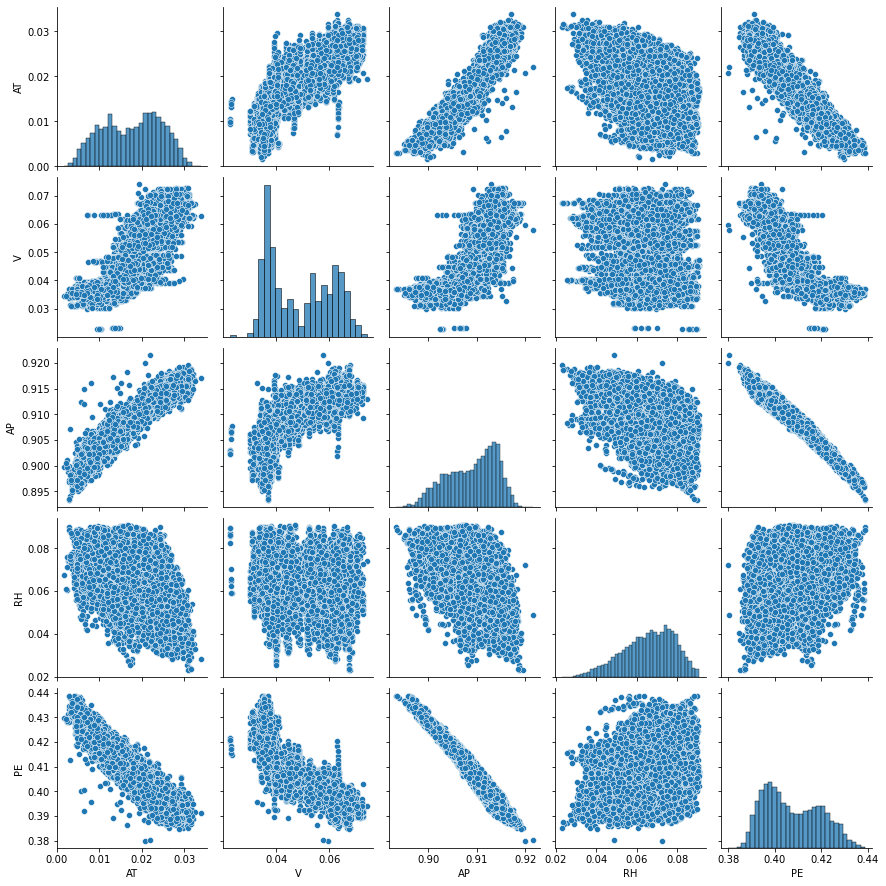

In [52]:
#normalizing the data:
df_nor=preprocessing.normalize(df)
df_nor=pd.DataFrame(df_nor)
df_nor.columns = df.columns
sns.pairplot(df_nor)
df_nor.corr()

[]

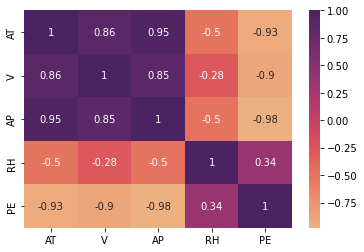

In [53]:
sns.heatmap(df_nor.corr(method="spearman"), annot=True, cmap='flare')
plt.plot()

**We infer from above heatmap that there is high negative correlation between AP, V, AT features with Power Output.
We also see the predictor features (AT and V) are highly correlated to each other. This is usually not a good thing as our features should be independent of each other. This problem is called multicollinearity.**

In [54]:
X_nor=df_nor.iloc[:,0:4]
y_nor=df_nor.iloc[:,4]

## Splitting train-test set on dataset after preprocessing.normalize

In [55]:
X_nor_train,X_nor_test,y_nor_train,y_nor_test=model_selection.train_test_split(X_nor,y_nor,test_size=0.2)
print(X_nor_train.shape)
print(X_nor_test.shape)
print(y_nor_train.shape)
print(y_nor_test.shape)

(7654, 4)
(1914, 4)
(7654,)
(1914,)


## Fitting linear model on dataset after preprocessing.normalize

In [56]:
lr_nor=LinearRegression()
lr_nor_model=lr_nor.fit(X_nor_train,y_nor_train)
pred=lr_nor.predict(X_nor_test)
print(pred)
print(lr_nor_model.coef_)
print(lr_nor_model.intercept_)

[0.41667931 0.41838024 0.4314291  ... 0.39564731 0.39146821 0.40092872]
[-0.0624025  -0.14248342 -2.13729882 -0.14736742]
2.3681986526598076


In [57]:
print(f"training score--->{lr_nor_model.score(X_nor_train,y_nor_train)}")
print(f"testing score--->{lr_nor_model.score(X_nor_test,y_nor_test)}")

training score--->0.9990034093616491
testing score--->0.9989783855955331


# Checking Accuracy using different methods

## 1. Root Mean Squared Error (RMSE) 

It measures the average error performed by the model in predicting the outcome for an observation.

**The lower the RMSE score the better**

In [58]:
from sklearn.metrics import mean_squared_error
mse = mean_squared_error(y_nor_test, pred)
rmse = np.sqrt(mse)
rmse

0.00037266702940599053

## 2. R-Squared

It means how much of the variation in the target variable that can be explained by the set of features used in training the model.

**The higher the R-squared score the better**

In [59]:
from sklearn.metrics import r2_score
r_squared = r2_score(y_nor_test, pred)
r_squared

0.9989783855955331

## 3. Mean Absolute Error

It measures how far predicted values are away from the actual values.

**The lower the MAE value the better**

In [60]:
from sklearn.metrics import mean_absolute_error
mae = mean_absolute_error(y_nor_test, pred)
mae

0.0002930975164417188

# Other Model

## Random Forest Regressor

### using original dataset

In [61]:
from sklearn.ensemble import RandomForestRegressor
rf_regressor= RandomForestRegressor()
rf_regressor.fit(X_train, y_train)
y_pred = rf_regressor.predict(X_test)

In [62]:
print(f"training score--->{rf_regressor.score(X_train,y_train)}")
print(f"testing score--->{rf_regressor.score(X_test,y_test)}")

training score--->0.9945006493987071
testing score--->0.9636141750360206


### using dataset after preprocessing.normalize

In [63]:
rf_regressor_nor= RandomForestRegressor()
rf_regressor_nor.fit(X_nor_train, y_nor_train)
y_pred_nor = rf_regressor_nor.predict(X_nor_test)

In [64]:
print(f"training score--->{rf_regressor_nor.score(X_nor_train,y_nor_train)}")
print(f"testing score--->{rf_regressor_nor.score(X_nor_test,y_nor_test)}")

training score--->0.9999209785548041
testing score--->0.9993304026652555


# Conclusion

* There is high negative correlation between AP, V, AT features with Power Output
* We also see the predictor features (AT and V) are highly correlated to each other
* We don't see any change in the accuracy of linear regression model after using  ridge regularization
* Accuracy of linear regression model increased from 92% to 99% after preprocessing.normalize()
* Accuracy of random forest regressor model has increaded from 96% to 99% after preprocessing using normalize